# k-scheduling tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample, seed

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.algorithms import amplitude_estimators, EstimationProblem
from qiskit.algorithms import IterativeAmplitudeEstimation as BaseIterativeAmplitudeEstimation
# from qiskit.extensions import UnitaryGate

from algorithms import IterativeAmplitudeEstimation, MaximumLikelihoodAmplitudeEstimation, FasterAmplitudeEstimation
from operators import *

In [2]:
n = 4
N = 2**n
k = N//2
marked = sample(range(N), k)

In [3]:
# Define the estimation problem and oracle function
def good_state(state):
    bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
    return (state in bin_marked)

problem = EstimationProblem(
    state_preparation=A(n),  # A operator
    grover_operator=Q(n, marked),  # Q operator
    objective_qubits=range(n),
    is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

problem2 = EstimationProblem(
    state_preparation=A(n),  # A operator
    grover_operator=Q(n, marked),  # Q operator
    objective_qubits=range(n),
    is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 100

## IQAE: attempt exponential decay in the number of shots per iteration to account for deeper circuits.

In [5]:
# TODO: package this in a function to make it nicer / generalize

# n_trials = 100
# max_depth_log2 = 5
# queries = np.zeros((max_depth_log2-1, n_trials))
# errs = np.zeros((max_depth_log2-1, n_trials))

# for i in range(2,max_depth_log2+1):
#     for j in range(n_trials):
#         mlae = MLAE(range(i), quantum_instance=aer_sim)
#         result = mlae.estimate(problem)
#         queries[i-2,j] = result.num_oracle_queries
#         errs[i-2,j] = abs(k/N - result.estimation)

In [6]:
# parameters for IQAE
alpha = 0.05
confint_method = 'chernoff'

In [7]:
powers = range(2,7)
epsilons = [(1.0 / (10**power)) for power in powers]
iae_results = [] 
biae_results = []
for i, epsilon in enumerate(epsilons):
    print('epsilon:',epsilon)
    IAE = IterativeAmplitudeEstimation(epsilon_target=epsilon, alpha=alpha, confint_method=confint_method, quantum_instance=aer_sim)
    BIAE = BaseIterativeAmplitudeEstimation(epsilon_target=epsilon, alpha=alpha, confint_method=confint_method, quantum_instance=aer_sim)
    iae_result = IAE.estimate(problem)
    biae_result = BIAE.estimate(problem2)
    iae_results.append(iae_result)
    biae_results.append(biae_result)
    print()

epsilon: 0.01
0.049775
1 129 0
2 45 0
3 16 0
4 6 0
5 2 0
6 1 0

epsilon: 0.001
0.049775
1 1289 0
2 447 3
3 157 17
4 56 53
5 20 116
6 7 116
7 3 116
8 1 116

epsilon: 0.0001
0.049775
1 12890 0
2 4467 15
3 1572 292
4 558 3542

epsilon: 1e-05
0.049775
1 128897 0
2 44675 49
3 15719 3021

epsilon: 1e-06
0.049775
1 1288972 0
2 446749 143
3 157188 28954



In [8]:
IAE_RESULT = iae_results
BIAE_RESULT = biae_results

In [9]:
iae_epsilon = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in IAE_RESULT]
iae_nshots  = [res.num_oracle_queries for res in IAE_RESULT]

biae_epsilon = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in BIAE_RESULT]
biae_nshots  = [res.num_oracle_queries for res in BIAE_RESULT]

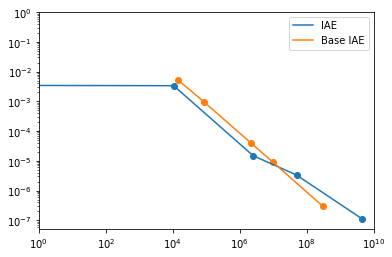

In [10]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(iae_nshots, iae_epsilon)
ax.plot(iae_nshots, iae_epsilon)
ax.scatter(biae_nshots, biae_epsilon)
ax.plot(biae_nshots, biae_epsilon)
ax.legend(['IAE', 'Base IAE'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(1, 10**10)
plt.show()

In [11]:
biae_nshots

[14336, 83968, 2151424, 9889792, 302848000]

In [12]:
iae_nshots

[0, 10574, 2502465, 49676174, 4615106459]

In [15]:
np.array(biae_nshots) - np.array(iae_nshots)

array([      14336,       73394,     -351041,   -39786382, -4312258459])